In [5]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# 엑셀 파일을 읽어오기
file_path = 'f_perp.xlsx'  # 실제 파일 경로로 대체해주세요
data = pd.read_excel(file_path)

# angle_y 열의 데이터 가져오기
angle_y = data['ax(g)']

# +에서 -가 되는 피크 찾기
pos_peaks, _ = find_peaks(angle_y, height=-50)  # 양수 피크 찾기
neg_peaks, _ = find_peaks(-angle_y, height=-100)  # 음수 피크 찾기

# 피크의 인덱스와 값을 출력
peaks = np.concatenate((pos_peaks, neg_peaks))
peaks.sort()
peak_indices = peaks + 1  # 엑셀의 행은 1부터 시작하므로 인덱스를 맞추기 위해 +1
peak_values = angle_y.iloc[peaks]
peaks_df = pd.DataFrame({'Peak Index': peak_indices, 'Peak Value': peak_values})
print(peaks_df)

      Peak Index  Peak Value
2              3      0.0088
6              7      0.0063
8              9      0.0083
9             10      0.0073
10            11      0.0083
...          ...         ...
2089        2090      0.0073
2092        2093      0.0093
2093        2094      0.0068
2096        2097      0.0088
2098        2099      0.0063

[684 rows x 2 columns]


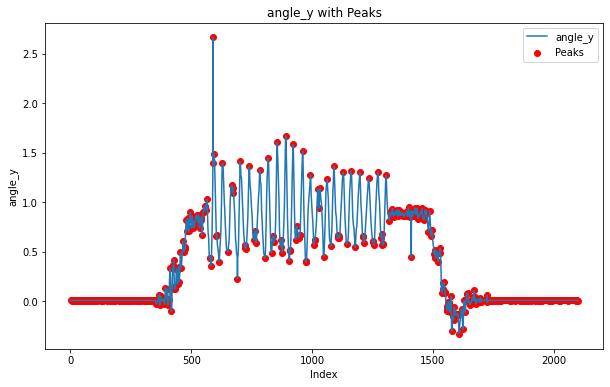

In [6]:
import matplotlib.pyplot as plt

# angle_y 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(angle_y, label='angle_y')
plt.scatter(peaks, angle_y.iloc[peaks], color='red', marker='o', label='Peaks')
plt.xlabel('Index')
plt.ylabel('angle_y')
plt.title('angle_y with Peaks')
plt.legend()
plt.show()


1.9120000000000008
상위 이상점 기준: 0.4647526624653898
하위 이상점 기준: -0.46475998310960653


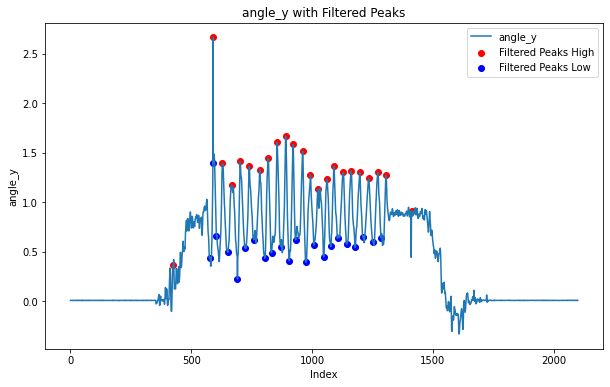

In [7]:
# 피크 간 값(value) 간격 계산
peak_values = angle_y.iloc[peaks]
peak_gaps = np.diff(peak_values)

# peak_gaps의 표준 편차와 평균 계산
std_dev = np.std(peak_gaps)
mean_value = np.mean(peak_gaps)

def adjust_std_multiplier(peak_gaps):
    std_multiplier = 1  # 초기값
    while True:
        threshold_high = np.mean(peak_gaps) + std_multiplier * np.std(peak_gaps)
        outliers_count = len(peak_gaps[peak_gaps > threshold_high]) + len(peak_gaps[peak_gaps < -threshold_high])

        if outliers_count > 45:  # 이상치 수가 일정 개수 이상일 때
            std_multiplier += 0.006  # 배수를 증가시킴
        else:
            break

    return std_multiplier

# 표준 편차의 배수 자동 조정 후 임계값 계산
std_multiplier = adjust_std_multiplier(peak_gaps)
print(std_multiplier)

threshold_high = mean_value + std_multiplier * std_dev
threshold_low = mean_value - std_multiplier * std_dev

# 계산된 임계값 출력
print("상위 이상점 기준:", threshold_high)
print("하위 이상점 기준:", threshold_low)

filtered_peaks_high = peaks[np.where(peak_gaps > threshold_high)[0] + 1]
filtered_peaks_low = peaks[np.where(peak_gaps < threshold_low)[0] + 1]
filtered_peaks = peaks[np.where((peak_gaps > threshold_high) | (peak_gaps < threshold_low))[0] + 1]


# angle_y 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(angle_y, label='angle_y')  
plt.scatter(filtered_peaks_high, angle_y.iloc[filtered_peaks_high], color='red', marker='o', label='Filtered Peaks High')
plt.scatter(filtered_peaks_low, angle_y.iloc[filtered_peaks_low], color='blue', marker='o', label='Filtered Peaks Low')
plt.xlabel('Index')
plt.ylabel('angle_y')
plt.title('angle_y with Filtered Peaks')
plt.legend()
plt.show()


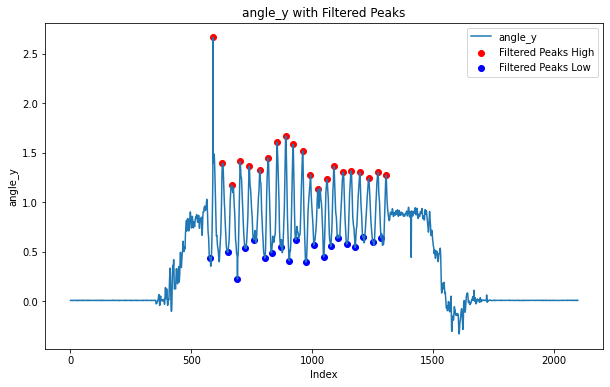

In [8]:
# 남겨질 peaks를 담을 리스트 초기화
remaining_peaks = []

# 이전 peak의 값과 인덱스 초기화
prev_peak_value = None
prev_peak_index = None


is_high = None

# high와 low를 분리할 리스트 초기화
remaining_peaks_high = []
remaining_peaks_low = []

# peaks를 순회하며 조건에 맞게 처리
for peak_index in filtered_peaks:
    # 이전 peak가 있고, 현재 peak가 이전 peak와 연속되는 경우
    is_high = peak_index in filtered_peaks_high
    curr_peak_value = angle_y.iloc[peak_index]
    if prev_peak_index is not None and prev == is_high:
        # 이전 peak와 비교하여 더 큰 값을 유지
        if is_high and curr_peak_value > prev_peak_value:
            # 현재 peak가 high이고 더 큰 값이면 이전 peak를 제거하고 현재 peak로 대체
            remaining_peaks.remove(prev_peak_index)
            remaining_peaks.append(peak_index)
            prev_peak_value = curr_peak_value  # 이전 peak의 값을 갱신
        elif not is_high and curr_peak_value > prev_peak_value:
            # 현재 peak가 low이고 더 작은 값이면 이전 peak를 제거하고 현재 peak로 대체
            remaining_peaks.remove(prev_peak_index)
            remaining_peaks.append(peak_index)
            prev_peak_value = curr_peak_value  # 이전 peak의 값을 갱신
        else:
            continue  # 값이 더 작거나 크지 않은 경우, 건너뜀
    else:
        if is_high:
            remaining_peaks_high.append(peak_index)
        else:
            remaining_peaks_low.append(peak_index)
        if prev_peak_index is not None and prev != is_high and not is_high and curr_peak_value > prev_peak_value:
            remaining_peaks.remove(prev_peak_index)
            remaining_peaks.append(peak_index)
            remaining_peaks_high.remove(prev_peak_index)
        elif prev_peak_index is not None and prev != is_high and is_high and curr_peak_value < prev_peak_value:
            remaining_peaks.remove(prev_peak_index)
            remaining_peaks.append(peak_index)
            remaining_peaks_low.remove(prev_peak_index)
        else:
            # 연속되지 않는 경우에는 그대로 유지
            remaining_peaks.append(peak_index)
        prev_peak_value = angle_y.iloc[peak_index]  # 이전 peak의 값을 갱신
        prev_peak_index = peak_index  # 이전 peak의 인덱스를 갱신
        prev = is_high
        # 현재 peak가 high인지 low인지에 따라 분리
        

import matplotlib.pyplot as plt

# angle_y 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(angle_y, label='angle_y')
plt.scatter(remaining_peaks_high, angle_y.iloc[remaining_peaks_high], color='red', marker='o', label='Filtered Peaks High')
plt.scatter(remaining_peaks_low, angle_y.iloc[remaining_peaks_low], color='blue', marker='o', label='Filtered Peaks Low')
#plt.scatter(remaining_peaks, angle_y.iloc[remaining_peaks], color='blue', marker='o', label='Filtered Peaks Low')
plt.xlabel('Index')
plt.ylabel('angle_y')
plt.title('angle_y with Filtered Peaks')
plt.legend()
plt.show()